In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
import dateutil.relativedelta

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
tables = Base.classes.keys()
tables

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes['measurement']
Station = Base.classes['station']

In [9]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

In [11]:
# Calculate the date 1 year ago from the last data point in the database

# Get latest date from database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first().date

# Convert latest date into datetime format so we can subtract a year from it to get filter date
formatted_last_date = dt.datetime.strptime(last_date, '%Y-%m-%d')
filter_date = formatted_last_date - dateutil.relativedelta.relativedelta(months=12)
filter_date

datetime.datetime(2016, 8, 23, 0, 0)

In [12]:
# Perform a query to retrieve the data and precipitation scores
rain_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= filter_date).statement

# Save the query results as a Pandas DataFrame and set the index to the date column
rain_data_df = pd.read_sql_query(rain_data, session.bind)
rain_data_df = rain_data_df.rename(columns={"date":"Date", "prcp": "Precipitation"})
rain_data_df = rain_data_df.set_index(['Date'])
rain_data_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [13]:
# Sort the dataframe by date
rain_data_df = rain_data_df.sort_values(['Date'])
rain_data_df.head()

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,NaN
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,2.15


In [14]:
xmin = formatted_last_date
xmax = filter_date
xlabels = pd.date_range(start = filter_date, end = formatted_last_date, periods = 12).tolist()

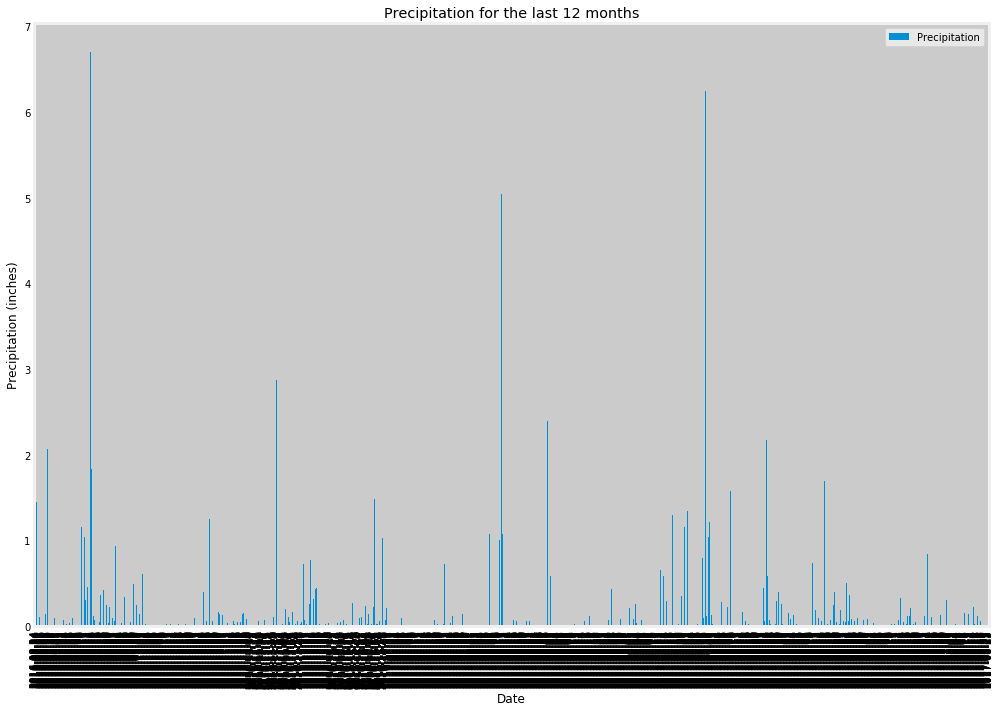

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
rain_data_df.plot(kind='bar', title = 'Precipitation for the last 12 months', figsize=(14,10))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
# plt.locator_params(axis='x')
ax = plt.gca()
xmin = filter_date # np.min(X)
xmax = formatted_last_date # np.max(X)
ax.set_xlim([xmin, xmax])
ax.set_xticks(xlabels)
ax.set_xticklabels(xlabels,rotation=90)
ax.grid(True)
plt.tight_layout()
plt.savefig('Output/Hawaii_Precipitation.png')


In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
rain_data_df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Measurement.station).distinct(Measurement.station).count()
total_stations

9

In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc())
for station in stations:
    print(f"{station[0]} has {station[1]} records")

USC00519281 has 2772 records
USC00519397 has 2724 records
USC00513117 has 2709 records
USC00519523 has 2669 records
USC00516128 has 2612 records
USC00514830 has 2202 records
USC00511918 has 1979 records
USC00517948 has 1372 records
USC00518838 has 511 records


In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').scalar()
USC00519281_df = pd.DataFrame({'Statistic':['Minimum', 'Maximum', 'Average'],
                              'Temperature':[lowest_temp, highest_temp, avg_temp]})
USC00519281_df

,Statistic,Temperature
0,Minimum,54.000000
1,Maximum,85.000000
2,Average,71.663781


USC00519281 station has the most temperature  observations


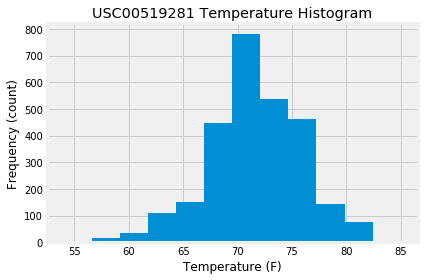

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_temps_station = session.query(Measurement.station).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
print(f'{most_temps_station[0]} station has the most temperature  observations')                                                                             

# station_temps = session.query(Measurement.tobs,func.count(Measurement.tobs)).group_by(Measurement.tobs).order_by(Measurement.tobs).\
#                             filter(Measurement.station == most_temps_station[0])

# temps=[]
# frequency=[]
# for temp in station_temps:
#     temps.append(temp[0])
#     frequency.append(temp[1])


station_temps = session.query(Measurement.tobs).order_by(Measurement.tobs).filter(Measurement.station == most_temps_station[0])

temps=[]
for temp in station_temps:
    temps.append(temp[0])

temp_freq_df = pd.DataFrame({'Temperatures':temps})
temp_freq_df.hist(bins=12)
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency (count)')
plt.title(f'{most_temps_station[0]} Temperature Histogram')
plt.tight_layout()
plt.savefig('Output/Temperature_Histogram.png')
    
    
    






In [21]:
session.close()

## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
